# Word2Vec - English

In [3]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

    1. 데이터 load
    
    - xml 문법으로 작성되어 있어, 전처리 필요함
    - <content>와 </content> 사이의 내용 필요함
    - xml 문법 제거한 후 <content>와 </content> 사이의 내용에서 (Laughter)와 (Applause) 같은 배경음 제거

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x2acac45d8e0>)

    2. 전처리

In [15]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [18]:
print(f'총 샘플의 개수 : {len(result)}')

총 샘플의 개수 : 273380


In [19]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


    3. word2vec 훈련
    
    """
        Word2Vec hyperparameter

        vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
        window = 컨텍스트 윈도우 크기
        min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
        workers = 학습을 위한 프로세스 수
        sg = 0은 CBOW, 1은 Skip-gram 
        
    """

In [20]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [23]:
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

In [25]:
# 입력한 단어에 가장 유사한 단어 출력

model_result = model.wv.most_similar('man')
model_result

[('woman', 0.8545859456062317),
 ('guy', 0.8031389713287354),
 ('boy', 0.7754290699958801),
 ('lady', 0.751112699508667),
 ('soldier', 0.7428959608078003),
 ('girl', 0.7331405878067017),
 ('poet', 0.7247343063354492),
 ('gentleman', 0.7197877168655396),
 ('kid', 0.7196550965309143),
 ('rabbi', 0.6682697534561157)]

    -> man과 유사한 단어로 woman, guy, boy, lady, soldier, girl, poet, gentleman, kid, rabbi 출력
    : Word2Vec을 통해 단어의 유사도 계산 가능

    4. Word2Vec 모델 저장하고 로드

In [26]:
# 모델 저장
model.wv.save_word2vec_format('eng_w2v')

In [27]:
# 모델 로드
loaded_model = KeyedVectors.load_word2vec_format('eng_w2v')

In [28]:
model_result = loaded_model.most_similar('man')
model_result

[('woman', 0.8545859456062317),
 ('guy', 0.8031389713287354),
 ('boy', 0.7754290699958801),
 ('lady', 0.751112699508667),
 ('soldier', 0.7428959608078003),
 ('girl', 0.7331405878067017),
 ('poet', 0.7247343063354492),
 ('gentleman', 0.7197877168655396),
 ('kid', 0.7196550965309143),
 ('rabbi', 0.6682697534561157)]

# Word2Vec - Korean

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

    1. 데이터 로드

In [31]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x2ad14e01820>)

In [32]:
train_data = pd.read_table('ratings.txt')

In [33]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [34]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [35]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


    2. 전처리

In [36]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [37]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [38]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [39]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [41]:
from tqdm import tqdm

In [42]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [25:32<00:00, 130.53it/s]


    3. EDA

리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.338453538141525


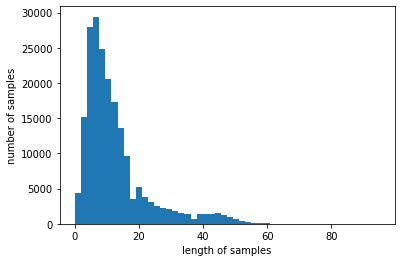

In [43]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

    4. Word2Vec 학습

In [44]:
from gensim.models import Word2Vec

In [46]:
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [47]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(17615, 100)

In [48]:
print(model.wv.most_similar("호러"))

[('슬래셔', 0.869688868522644), ('정통', 0.8560253977775574), ('느와르', 0.8509597182273865), ('히어로', 0.8498680591583252), ('SF', 0.8494759798049927), ('무협', 0.8453491926193237), ('고어', 0.8308864235877991), ('블록버스터', 0.8293848037719727), ('sf', 0.8246084451675415), ('하이', 0.8189855813980103)]


# Pre-training 된 Word2Vec embedding


    <English>
    
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

    - 구글에서 제공한 사전 훈련된 Word2Vec 모델 사용
    - 약 3백만 개의 Word2Vec 단어 제공. 각 embedding vector의 dimension은 300
    
    
    <Korean>
https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view    

    - 박규병님의 한글버전 word2Vec